# XGBoost Data Preparation

A lot of work has gone into compiling the current dataset. I have merged the gps_df, sectionals_df and results_df. I have limited the amount of Equibase data I am using just to keep the focus on the TPD GPS data, and to do some feature engineering.  However, there are some good metrics from the Equibase data that are just basic measures that could be obtained from any racebook sheet. 

## Get Started

1. Going to load the parquet DataFrame from disk and do some imputation, one-hot encoding, string indexing, and scaling. The run it through XBBoost to see how it's looking. At this point I will do the integration of route data, and add the GPS aggregations. I just want to see what I can minimally do and how its working before I go down the wrong path. If the XGBoost doesn't do any better than the LSTM, at least I won't have wasted any more time on it. 

### Load master_results_df.parquet file

In [1]:
# Setup Environment

import os
import logging
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn import set_config
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as spark_min, max as spark_max , 
                                   row_number, mean, countDistinct, last, first, when)
import configparser
from pyspark.sql import SparkSession
from src.data_preprocessing.data_prep1.sql_queries import sql_queries
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Window
from src.data_preprocessing.data_prep1.data_utils import (save_parquet, gather_statistics, 
                initialize_environment, load_config, initialize_logging, initialize_spark, 
                identify_and_impute_outliers, 
                identify_and_remove_outliers, identify_missing_and_outliers)
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
import pandas as pd

# Set global references to None
spark = None
master_results_df = None

In [3]:

spark, jdbc_url, jdbc_properties, queries, parquet_dir, log_file = initialize_environment()


2024-12-30 22:03:47,696 - INFO - Environment setup initialized.


Spark session created successfully.


In [4]:
train_df = spark.read.parquet(os.path.join(parquet_dir, "train_df.parquet"))
val_df = spark.read.parquet(os.path.join(parquet_dir, "val_df.parquet"))
test_df = spark.read.parquet(os.path.join(parquet_dir, "test_df.parquet"))

In [5]:
columns_to_drop = [
    "course_cd", "trk_cond", "jock_key", "train_key", "sex", "equip", "surface", "weather",
    "med", "race_type", "stk_clm_md", "turf_mud_mark",
    "course_cd_ohe", "equip_ohe", "surface_ohe", "trk_cond_ohe", "weather_ohe",
    "med_ohe", "stk_clm_md_ohe", "turf_mud_mark_ohe", "race_type_ohe"
]

train_df = train_df.drop(*columns_to_drop)
test_df = test_df.drop(*columns_to_drop)
val_df = val_df.drop(*columns_to_drop)


In [6]:
train_df.printSchema()

root
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- date_of_birth: date (nullable = true)
 |-- start_position: long (nullable = true)
 |-- gate_index: integer (nullable = true)
 |-- jock_key_index: double (nullable = true)
 |-- train_key_index: double (nullable = true)
 |-- course_cd_index: double (nullable = true)
 |-- equip_index: double (nullable = true)
 |-- surface_index: double (nullable = true)
 |-- trk_cond_index: double (nullable = true)
 |-- weather_index: double (nullable = true)
 |-- med_index: double (nullable = true)
 |-- stk_clm_md_index: double (nullable = true)
 |-- turf_mud_mark_index: double (nullable = true)
 |-- race_type_index: double (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [7]:

def split_scaled_features(df):
    """
    Splits a Vector column ('scaled_features') into individual feature columns.
    """
    # Convert the Vector to an ArrayType column for processing
    df = df.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

    # Dynamically extract the array length for column generation
    num_features = len(df.first()["scaled_features_array"])

    # Create new feature columns by extracting each array element
    for i in range(num_features):
        feature_name = f"feature_{i}"
        df = df.withColumn(feature_name, col("scaled_features_array")[i])

    # Drop the original Vector and intermediate ArrayType columns
    return df.drop("scaled_features", "scaled_features_array")



In [8]:
# Apply to your datasets
train_df = split_scaled_features(train_df)
test_df = split_scaled_features(test_df)
val_df = split_scaled_features(val_df)

In [9]:
train_df.printSchema()

root
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- date_of_birth: date (nullable = true)
 |-- start_position: long (nullable = true)
 |-- gate_index: integer (nullable = true)
 |-- jock_key_index: double (nullable = true)
 |-- train_key_index: double (nullable = true)
 |-- course_cd_index: double (nullable = true)
 |-- equip_index: double (nullable = true)
 |-- surface_index: double (nullable = true)
 |-- trk_cond_index: double (nullable = true)
 |-- weather_index: double (nullable = true)
 |-- med_index: double (nullable = true)
 |-- stk_clm_md_index: double (nullable = true)
 |-- turf_mud_mark_index: double (nullable = true)
 |-- race_type_index: double (nullable = true)
 |-- feature_0: double (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: double (nullable = true)
 |-- feature_3: double (nullable = true)
 |-- feature_4: double (nullable 

In [10]:
# Define numeric columns for scaling
numeric_cols = [
    "avg_speed_agg", "max_speed_agg", "avg_stride_freq_agg", "final_speed_agg",
    "avg_accel_agg", "fatigue_agg", "sectional_time_agg", "running_time_agg",
    "distance_back_agg", "distance_ran_agg", "strides_agg", "max_speed_overall",
    "min_speed_overall", "distance_meters", "purse", "wps_pool", "weight",
    "claimprice", "power", "morn_odds", "avgspd", "class_rating", "net_sentiment",
    "avg_spd_sd", "ave_cl_sd", "hi_spd_sd", "pstyerl", "all_starts", "all_win",
    "all_place", "all_show", "all_fourth", "all_earnings", "cond_starts",
    "cond_win", "cond_place", "cond_show", "cond_fourth", "cond_earnings",
    "age_at_race_day"
]

feature_mapping = {f"feature_{i}": col_name for i, col_name in enumerate(numeric_cols)}
# print(feature_mapping)

In [11]:
# Convert Spark DataFrame to Pandas
train_pd = train_df.toPandas()
val_pd = val_df.toPandas()
test_pd = test_df.toPandas()

In [12]:
# Extract features and labels
feature_cols = [col for col in train_pd.columns if col.startswith("feature_")]
X_train = train_pd[feature_cols].values
y_train = train_pd["label"].values

X_val = val_pd[feature_cols].values
y_val = val_pd["label"].values

X_test = test_pd[feature_cols].values
y_test = test_pd["label"].values

In [13]:
set_config(display="text")  # Switch to text-based display

xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=8,               # Number of classes (0 to 7)
    max_depth=6,               # Tree depth
    learning_rate=0.1,         # Learning rate
    n_estimators=100,          # Number of trees
    eval_metric="mlogloss",    # Log loss for multi-class
    early_stopping_rounds=10   # Specify early stopping rounds here
)

In [14]:
# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True  # Use verbose for training progress
)


[0]	validation_0-mlogloss:2.03895	validation_1-mlogloss:2.04058
[1]	validation_0-mlogloss:2.00553	validation_1-mlogloss:2.00871
[2]	validation_0-mlogloss:1.97702	validation_1-mlogloss:1.98171
[3]	validation_0-mlogloss:1.95202	validation_1-mlogloss:1.95824
[4]	validation_0-mlogloss:1.93001	validation_1-mlogloss:1.93777
[5]	validation_0-mlogloss:1.91027	validation_1-mlogloss:1.91966
[6]	validation_0-mlogloss:1.89264	validation_1-mlogloss:1.90353
[7]	validation_0-mlogloss:1.87667	validation_1-mlogloss:1.88909
[8]	validation_0-mlogloss:1.86216	validation_1-mlogloss:1.87615
[9]	validation_0-mlogloss:1.84888	validation_1-mlogloss:1.86434
[10]	validation_0-mlogloss:1.83669	validation_1-mlogloss:1.85364
[11]	validation_0-mlogloss:1.82561	validation_1-mlogloss:1.84402
[12]	validation_0-mlogloss:1.81550	validation_1-mlogloss:1.83530
[13]	validation_0-mlogloss:1.80598	validation_1-mlogloss:1.82724
[14]	validation_0-mlogloss:1.79727	validation_1-mlogloss:1.81988
[15]	validation_0-mlogloss:1.78908	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=8, num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
#!pip show xgboost
#!pip show scikit-learn

In [ ]:
#print(xgb_model.get_params())

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.59      0.53     10196
           1       0.26      0.32      0.29     10182
           2       0.21      0.22      0.21     10176
           3       0.18      0.13      0.15     10124
           4       0.20      0.17      0.18      9938
           5       0.21      0.13      0.16      9125
           6       0.20      0.02      0.03      7373
           7       0.40      0.71      0.51     12555

    accuracy                           0.31     79669
   macro avg       0.27      0.29      0.26     79669
weighted avg       0.28      0.31      0.28     79669

Confusion Matrix:
[[5985 2456  902  367  216   54    4  212]
 [3076 3291 1747  766  616  183   18  485]
 [1547 2596 2201 1209 1062  474   30 1057]
 [ 891 1806 1946 1329 1607  803   64 1678]
 [ 497 1124 1441 1312 1648 1134  128 2654]
 [ 267  616  990  986 1437 1187  130 3512]
 [ 124  367  576  652  952  917  131 3654]
 [ 114 

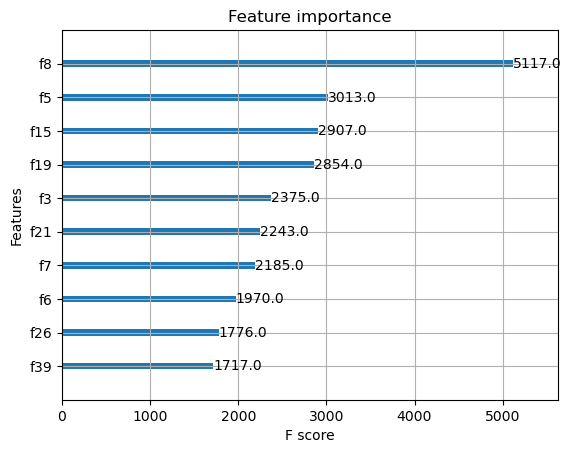

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, max_num_features=10)  # Top 10 features
plt.show()

In [18]:

# Define important keys based on `feature_` naming
important_keys = ["feature_8", "feature_5", "feature_15", "feature_19", "feature_3", 
                  "feature_21", "feature_7", "feature_6", "feature_26", "feature_39"]

# Extract important features
important_features = {key: feature_mapping[key] for key in important_keys}

# Print the result
print("Important Features:")
for key, value in important_features.items():
    print(f"{key}: {value}")

Important Features:
feature_8: distance_back_agg
feature_5: fatigue_agg
feature_15: wps_pool
feature_19: morn_odds
feature_3: final_speed_agg
feature_21: class_rating
feature_7: running_time_agg
feature_6: sectional_time_agg
feature_26: pstyerl
feature_39: age_at_race_day


### Class Weights:
Ensure class weights are applied during training to balance the influence of each class.

In [ ]:
class_weights = {i: len(y_train) / (8 * np.sum(y_train == i)) for i in np.unique(y_train)}
xgb_model.set_params(scale_pos_weight=class_weights)

### Hyperparameter Tuning

	•	If the performance is not satisfactory, tune hyperparameters like max_depth, min_child_weight, learning_rate, etc., using a grid search or random search.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

### Save and Reload Model
	•	Save the trained model for deployment or further analysis.

In [ ]:
import joblib

# Save model
joblib.dump(xgb_model, "xgb_model.pkl")

# Load model
xgb_model_loaded = joblib.load("xgb_model.pkl")

### Visualize Training Log
	•	Visualize the mlogloss over iterations to ensure there’s no overfitting.

In [ ]:
results = xgb_model.evals_result()

# Plot
plt.plot(results["validation_0"]["mlogloss"], label="Train")
plt.plot(results["validation_1"]["mlogloss"], label="Validation")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Training and Validation Log Loss")
plt.show()

### What to Watch For
	1.	Overfitting: If the validation loss diverges significantly from the training loss, regularization (e.g., gamma, alpha) might help.
	2.	Class Imbalance: Ensure the class weights or balanced datasets account for imbalances.
	3.	Interpretation: Pay attention to feature importance to validate the model’s behavior aligns with domain expectations.